# Predicting All-NBA Team and Player Salaries - Predicting All-NBA Team and Salary
---

In this notebook, we will build upon the groundwork laid by our webscraping, data cleaning, and exploratory data analysis. Our cleaned data now contains over 80 features, including player statistic (advanced, totals, and per-game), salary cap information, and team payroll data. With this, our objective is twofold:

1. <u>**All-NBA Team**</u>: First we will construct multiple regression models to predict voter share, which will ultimately enable us to discern the All-NBA Teams. By employing various regression techniques, we can gain valuable insights into the factors that influence the voters' decisions, helping us understand what distinguishes an All-NBA player from others. 
2. <u>**Salary**</u>: We will then also use regression modeling to predict player salaries, training on the intricate relationship between player performance, individual statistics, and their contracts. 

This process will involve trial and error as well as the application of GridSearch and RandomizedSearch techniques to fine-tune our models.

At the end of our analysis, we hope to unravel the complexities of the NBA landscape, discovering patterns and associations that govern player recognition in All-NBA Teams and their financial remuneration. These insights will inform decision-making processes and aid in the evaluation of player performance and compensation within the competitive realm of professional basketball.

Further detailed notebooks on the various segments of this project can be found at the following: 
- [01_Data_Acquisition](./01_Data_Acquisition.ipynb)
- [02_Data_Cleaning](./02_Data_Cleaning.ipynb)
- [03_Preliminary_EDA](./03_Preliminary_EDA.ipynb)
- [05_Data_Modeling_II](./05_Data_Modeling_II.ipynb)

For more information on the background, a summary of methods, and findings, please see the associated [README](../README.md) for this analysis.

## Contents

---

In [11]:
# pip install xgboost

     --------------------------------------- 70.9/70.9 MB 12.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [653]:
# pip install lightgbm

     ---------------------------------------- 1.3/1.3 MB 10.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import shap
import streamlit as st


from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor, VotingRegressor, AdaBoostRegressor, GradientBoostingRegressor
# LGBMRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# from sklearn.compose import ColumnTransformer
# from sklearn.neighbors import KNeighborsClassifier

import datetime

import warnings
warnings.filterwarnings('ignore') 

pd.options.display.max_rows = 400
pd.options.display.max_columns = 400

In [5]:
df = pd.read_csv('../data/clean/stats_main.csv')
df.head()

,player,pos,age,tm,g,pg_gs,pg_mp,pg_fg,pg_fga,pg_fg%,pg_3p,pg_3pa,pg_3p%,pg_2p,pg_2pa,pg_2p%,pg_efg%,pg_ft,pg_fta,pg_ft%,pg_orb,pg_drb,pg_trb,pg_ast,pg_stl,pg_blk,pg_tov,pg_pf,pg_pts,year,tot_gs,tot_mp,tot_fg,tot_fga,tot_fg%,tot_3p,tot_3pa,tot_3p%,tot_2p,tot_2pa,tot_2p%,tot_efg%,tot_ft,tot_fta,tot_ft%,tot_orb,tot_drb,tot_trb,tot_ast,tot_stl,tot_blk,tot_tov,tot_pf,tot_pts,adv_per,adv_ts%,adv_3par,adv_ftr,adv_orb%,adv_drb%,adv_trb%,adv_ast%,adv_stl%,adv_blk%,adv_tov%,adv_usg%,adv_ows,adv_dws,adv_ws,adv_ws/48,adv_obpm,adv_dbpm,adv_bpm,adv_vorp,gt1_pos,pos_5,pos_3,f,gu,midseason_trade,all_nba_team,pts_won,pts_max,share,all_nba_winner,n_allstar,all_star,salary,salary_adj,team,conf,div,w,l,w/l%,seed,champs,won_championship,salary_cap,salary_cap_adj,payroll,payroll_adj
0,Nick Anderson,SG,23,ORL,70,42.0,28,5.7,12.2,0.467,0.2,0.8,0.293,5.5,11.4,0.479,0.477,2.5,3.7,0.668,1.3,4.2,5.5,1.5,1.1,0.6,1.6,2.1,14.1,1990,42.0,1971,400.0,857.0,0.467,17.0,58.0,0.293,383.0,799.0,0.479,0.477,173.0,259.0,0.668,92.0,294.0,386.0,106.0,74.0,44.0,113.0,145.0,990.0,15.1,0.510,0.068,0.302,4.9,16.7,10.7,8.5,1.8,1.3,10.4,22.4,1.2,1.9,3.1,0.075,0.0,0.3,0.3,1.1,0,SG,Gu,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0,725000.0,1653775.0,Orlando Magic,W,M,31,51,0.378,19,Chicago Bulls,0,11871000.0,25499592.0,7532000.0,17181014.0
1,Ron Anderson,SF,32,PHI,82,13.0,28,6.2,12.9,0.485,0.1,0.5,0.209,6.1,12.3,0.497,0.490,2.0,2.4,0.833,1.3,3.2,4.5,1.4,0.8,0.2,1.2,2.0,14.6,1990,13.0,2340,512.0,1055.0,0.485,9.0,43.0,0.209,503.0,1012.0,0.497,0.490,165.0,198.0,0.833,103.0,264.0,367.0,115.0,65.0,13.0,100.0,163.0,1198.0,15.5,0.524,0.041,0.188,5.0,12.4,8.8,8.2,1.4,0.3,8.1,23.2,2.3,1.8,4.1,0.085,-0.2,-1.4,-1.6,0.2,0,SF,F,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0,425000.0,969454.0,Philadelphia 76ers,E,A,44,38,0.537,12,Chicago Bulls,0,11871000.0,25499592.0,11640000.0,26551652.0
2,Willie Anderson,SG,24,SAS,75,75.0,34,6.0,13.2,0.457,0.1,0.5,0.200,5.9,12.7,0.467,0.461,2.3,2.8,0.798,0.9,3.8,4.7,4.8,1.1,0.6,2.2,3.0,14.4,1990,75.0,2592,453.0,991.0,0.457,7.0,35.0,0.200,446.0,956.0,0.467,0.461,170.0,213.0,0.798,68.0,283.0,351.0,358.0,79.0,46.0,167.0,226.0,1083.0,13.0,0.499,0.035,0.215,3.1,11.5,7.5,20.2,1.5,1.1,13.3,20.1,1.3,3.5,4.8,0.089,-0.9,1.0,0.1,1.4,0,SG,Gu,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0,725000.0,1653775.0,San Antonio Spurs,W,M,55,27,0.671,6,Chicago Bulls,0,11871000.0,25499592.0,11057000.0,25221786.0
3,Thurl Bailey,PF,29,UTA,82,22.0,30,4.9,10.6,0.458,0.0,0.0,0.000,4.9,10.6,0.459,0.458,2.7,3.3,0.808,1.2,3.7,5.0,1.5,0.6,1.1,1.6,2.0,12.4,1990,22.0,2486,399.0,872.0,0.458,0.0,3.0,0.000,399.0,869.0,0.459,0.458,219.0,271.0,0.808,101.0,306.0,407.0,124.0,53.0,91.0,130.0,160.0,1017.0,12.5,0.513,0.003,0.311,5.1,13.6,9.6,7.7,1.1,2.3,11.6,20.0,0.6,3.1,3.7,0.072,-1.4,0.0,-1.4,0.4,0,PF,F,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0,1000000.0,2281070.0,Utah Jazz,W,M,54,28,0.659,7,Chicago Bulls,0,11871000.0,25499592.0,10695000.0,24396040.0
4,Benoit Benjamin,C,26,LAC,70,65.0,31,5.5,11.1,0.496,0.0,0.0,0.000,5.5,11.1,0.496,0.496,3.0,4.2,0.712,2.2,8.1,10.3,1.7,0.8,2.1,3.4,2.6,14.0,1990,65.0,2236,386.0,778.0,0.496,0.0,0.0,0.000,386.0,778.0,0.496,0.496,210.0,295.0,0.712,157.0,566.0,723.0,119.0,54.0,145.0,235.0,184.0,982.0,15.1,0.541,0.000,0.379,7.8,28.7,18.1,7.7,1.2,4.0,20.6,21.0,-0.7,3.7,3.0,0.064,-1.9,0.8,-1.1,0.5,0,C,C,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0,1750000.0,3991872.0,Los Angeles Clippers,W,P,31,51,0.378,18,Chicago Bulls,0,11871000.0,25499592.0,10245000.0,23369557.0


In [48]:
df.shape

(4377, 102)

In [6]:
train_yrs = [i for i in range(1990, 2017)] #1990-2016
test_yrs = [i for i in range(2017,2021)] #2017-2020
hold_yrs = [2021, 2022] 

In [234]:
feats = ['age', 'g', 'pg_gs', 'pg_mp', 'pg_fg', 'pg_fga', 'pg_fg%', 'pg_3p', 'pg_3pa', 'pg_3p%', 'pg_2p', 'pg_2pa', 'pg_2p%', 'pg_efg%', 'pg_ft', 'pg_fta', 'pg_ft%', 'pg_orb', 'pg_drb', 'pg_trb', 'pg_ast', 'pg_stl', 'pg_blk', 'pg_tov', 'pg_pf', 'pg_pts', 'tot_mp', 'tot_fg%', 'tot_3p', 'tot_3p%', 'tot_2p%', 'tot_efg%', 'tot_ft%', 'tot_pf', 'tot_pts', 'adv_per', 'adv_ts%', 'adv_3par', 'adv_ftr', 'adv_orb%', 'adv_drb%', 'adv_trb%', 'adv_ast%', 'adv_stl%', 'adv_blk%', 'adv_tov%', 'adv_usg%', 'adv_ows', 'adv_dws', 'adv_ws', 'adv_ws/48', 'adv_obpm', 'adv_dbpm', 'adv_bpm', 'adv_vorp', 'f', 'gu', 'w/l%', 'seed', 'all_star']

In [235]:
X_train = df[feats].loc[df.year.isin(train_yrs)].reset_index(drop=True)
X_test = df[feats].loc[df.year.isin(test_yrs)].reset_index(drop=True)

y_train = df['share'].loc[df.year.isin(train_yrs)]
y_test = df['share'].loc[df.year.isin(test_yrs)]

X_hold = df[feats].loc[df.year.isin(hold_yrs)].reset_index(drop=True)
y_hold = df['share'].loc[df.year.isin(hold_yrs)]

print(f'Train: X: {X_train.shape}, y: {y_train.shape}')
print(f'Test: X: {X_test.shape}, y: {y_test.shape}')
print(f'Hold: X: {X_hold.shape}, y: {y_hold.shape}')

Train: X: (3554, 60), y: (3554,)
Test: X: (520, 60), y: (520,)
Hold: X: (303, 60), y: (303,)


In [75]:
type(y_test)

pandas.core.series.Series

In [79]:
null_mod = y_train.mean()
null_mse = np.mean((y_train - null_mod)**2)
null_pred = np.full_like(y_test, y_train.mean())

print(f'Null Model: {null_mod}')
print(f'Null MSE: {null_mse}')
print(f'Null R^2: {mean_squared_error(y_test, null_pred)}')

Null Model: 0.06836268992684298
Null MSE: 0.04054201336316384
Null R^2: 0.04362410030724004


In [14]:
b1 = "\033[1m"
b0 = "\033[0m"

## Support Vector Regression

In [54]:
pipe_svr = Pipeline([
    ('sc', StandardScaler()),
    ('svr', SVR())
])

pipe_svr.get_params()

{'memory': None,
 'steps': [('ss', StandardScaler()), ('svr', SVR())],
 'verbose': False,
 'ss': StandardScaler(),
 'svr': SVR(),
 'ss__copy': True,
 'ss__with_mean': True,
 'ss__with_std': True,
 'svr__C': 1.0,
 'svr__cache_size': 200,
 'svr__coef0': 0.0,
 'svr__degree': 3,
 'svr__epsilon': 0.1,
 'svr__gamma': 'scale',
 'svr__kernel': 'rbf',
 'svr__max_iter': -1,
 'svr__shrinking': True,
 'svr__tol': 0.001,
 'svr__verbose': False}

In [74]:
pgrid_svr =[
    {
     'svr__C': np.linspace(0.0001, 2, 10),
     'svr__kernel': ['rbf'], #'poly', 'linear'
     'svr__degree': [2, 3, 4],
     'svr__gamma': ['scale','auto'],
     'svr__epsilon': [0.1, 0.5, 1]
    }
]

In [75]:
%%time

gs_svr = GridSearchCV(pipe_svr, pgrid_svr, n_jobs=25)
gs_svr.fit(X_train, y_train)

CPU times: total: 1.84 s
Wall time: 7.78 s


GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=25,
             param_grid=[{'svr__C': array([1.00000000e-04, 2.22311111e-01, 4.44522222e-01, 6.66733333e-01,
       8.88944444e-01, 1.11115556e+00, 1.33336667e+00, 1.55557778e+00,
       1.77778889e+00, 2.00000000e+00]),
                          'svr__degree': [2, 3, 4],
                          'svr__epsilon': [0.1, 0.5, 1],
                          'svr__gamma': ['scale', 'auto'],
                          'svr__kernel': ['rbf']}])

In [76]:
# Make predictions
preds_svr = gs_svr.predict(X_test)

In [77]:
print(f'----------------- {b1}SVR w/ GridSearch{b0} ----------------')
print(f'------------------ Train: {round(gs_svr.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(gs_svr.score(X_test, y_test),4)} -------------------')
print('Best Params:', gs_svr.best_params_)

----------------- SVR w/ GridSearch ----------------
------------------ Train: 0.8627 -------------------
------------------- Test: 0.7515 -------------------
Best Params: {'svr__C': 0.4445222222222222, 'svr__degree': 2, 'svr__epsilon': 0.1, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}


In [512]:
mse = mean_squared_error(y_test, preds_svr)
mse

0.008330220863588972

In [513]:
r2 = r2_score(y_test, preds_svr)
r2

0.8090421417646867

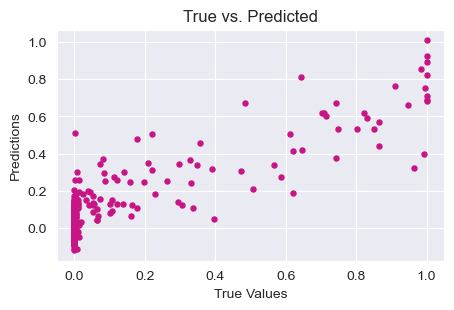

In [119]:
sns.set_style('darkgrid')
plt.figure(figsize=(5,3))
plt.scatter(y_test, preds_svr, s=13, c=['mediumvioletred'])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted')
plt.show()

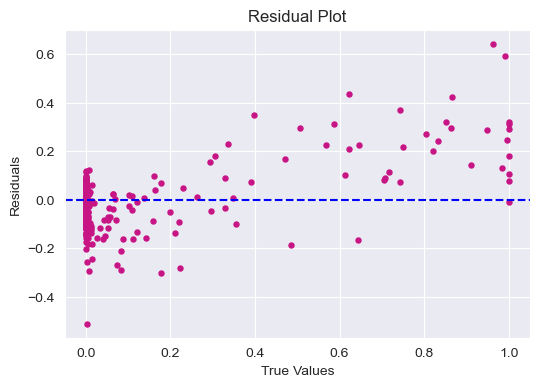

In [110]:
sns.set_style('darkgrid')
plt.figure(figsize=(6,4))
residuals = y_test - preds_svr
plt.scatter(y_test, residuals, s=13, c=['mediumvioletred'])
plt.axhline(y=0, color='blue', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

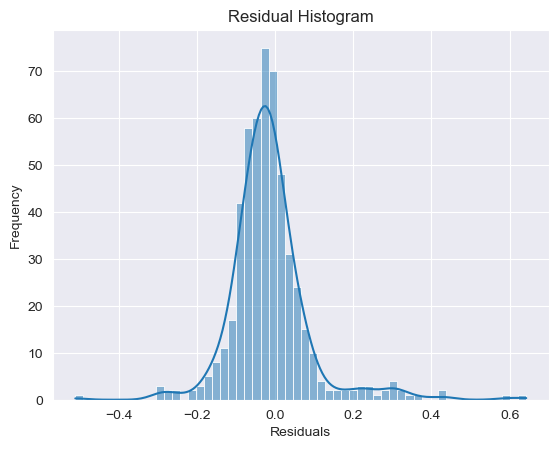

In [114]:
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Histogram')
plt.show()

## Random Forest Regressor

In [115]:
# RANDOM FOREST
pipe_rf = Pipeline([
    ('sc', StandardScaler()),
    ('rf', RandomForestRegressor())
])

pipe_rf.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()), ('rf', RandomForestRegressor())],
 'verbose': False,
 'sc': StandardScaler(),
 'rf': RandomForestRegressor(),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__criterion': 'squared_error',
 'rf__max_depth': None,
 'rf__max_features': 1.0,
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 100,
 'rf__n_jobs': None,
 'rf__oob_score': False,
 'rf__random_state': None,
 'rf__verbose': 0,
 'rf__warm_start': False}

In [126]:
pgrid_rf =[
    {'rf__n_estimators': [200],
     'rf__max_depth': [85],
     'rf__max_features': [10,15],
     'rf__max_leaf_nodes': [None],
     'rf__max_samples': [None]
    } 
]

In [127]:
%%time

gs_rf = GridSearchCV(pipe_rf, pgrid_rf, cv=5, n_jobs=25)
gs_rf.fit(X_train, y_train)

CPU times: total: 1.69 s
Wall time: 13.6 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('rf', RandomForestRegressor())]),
             n_jobs=25,
             param_grid=[{'rf__max_depth': [85], 'rf__max_features': [10, 15],
                          'rf__max_leaf_nodes': [None],
                          'rf__max_samples': [None],
                          'rf__n_estimators': [200]}])

In [128]:
preds_rf = gs_rf.predict(X_test)

In [129]:
print(f'------------- {b1}Random Forest w/ GridSearch{b0} ------------')
print(f'------------------- Train: {round(gs_rf.score(X_train, y_train),4)} --------------------')
print(f'------------------- Test: {round(gs_rf.score(X_test, y_test),4)} ---------------------')
print('Best Params:', gs_rf.best_params_)

------------- Random Forest w/ GridSearch ------------
------------------- Train: 0.9718 --------------------
------------------- Test: 0.7929 ---------------------
Best Params: {'rf__max_depth': 85, 'rf__max_features': 10, 'rf__max_leaf_nodes': None, 'rf__max_samples': None, 'rf__n_estimators': 200}


In [137]:
best_estimator = gs_rf.best_estimator_


In [160]:
# source: https://github.com/scikit-learn/scikit-learn/issues/21349, ChatGPT
best_estimator = gs_rf.best_estimator_
random_forest = best_estimator.named_steps['rf']
feature_importances = random_forest.feature_importances_
best_preprocessor = best_estimator.named_steps['sc']

feature_names = best_preprocessor.get_feature_names_out()
feature_names_list = list(feature_names)

print(feature_names)
print(feature_importances)

['age' 'g' 'pg_gs' 'pg_mp' 'pg_fg' 'pg_fga' 'pg_fg%' 'pg_3p' 'pg_3pa'
 'pg_3p%' 'pg_2p' 'pg_2pa' 'pg_2p%' 'pg_efg%' 'pg_ft' 'pg_fta' 'pg_ft%'
 'pg_orb' 'pg_drb' 'pg_trb' 'pg_ast' 'pg_stl' 'pg_blk' 'pg_tov' 'pg_pf'
 'pg_pts' 'tot_mp' 'tot_fg%' 'tot_3p' 'tot_3p%' 'tot_2p%' 'tot_efg%'
 'tot_ft%' 'tot_pf' 'tot_pts' 'adv_per' 'adv_ts%' 'adv_3par' 'adv_ftr'
 'adv_orb%' 'adv_drb%' 'adv_trb%' 'adv_ast%' 'adv_stl%' 'adv_blk%'
 'adv_tov%' 'adv_usg%' 'adv_ows' 'adv_dws' 'adv_ws' 'adv_ws/48' 'adv_obpm'
 'adv_dbpm' 'adv_bpm' 'adv_vorp' 'f' 'gu' 'w/l%' 'seed' 'all_star']
[0.00345372 0.0030971  0.0027812  0.00619622 0.03036739 0.01116469
 0.00377946 0.00220666 0.00265882 0.00322954 0.02612918 0.01121011
 0.00428796 0.00485886 0.0100053  0.01301063 0.00606572 0.00286429
 0.00742472 0.00524027 0.00863726 0.00362685 0.00295428 0.01597282
 0.00344872 0.0327362  0.00513544 0.00417904 0.00313888 0.0035471
 0.00400724 0.00432649 0.00513724 0.00446598 0.03905422 0.12487536
 0.00442538 0.00340424 0.00437026 0

In [162]:
# Make df
fi = pd.DataFrame({'feature_names':feature_names,
                   'feature_importance': feature_importances})

#Sort by creasing feature importance
fi.sort_values(by=['feature_importance'], ascending=False,inplace=True)
fi2 = fi.reset_index().drop(columns = ['index']).head(30)

,feature_names,feature_importance
0,adv_per,0.124875
1,adv_ws,0.116014
2,adv_vorp,0.091414
3,adv_ws/48,0.072610
4,adv_bpm,0.065975
5,adv_obpm,0.042708
6,all_star,0.041070
7,tot_pts,0.039054
8,pg_pts,0.032736
9,pg_fg,0.030367


Text(0, 0.5, 'Feature Names')

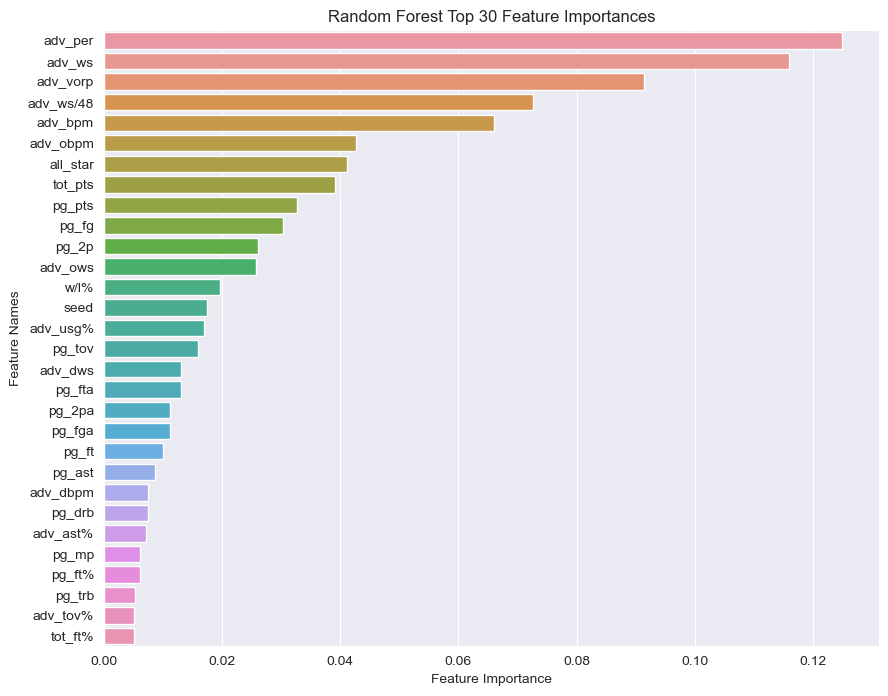

In [179]:
#Sort the DataFrame by descending
plt.figure(figsize=(10,8))
sns.barplot(x=fi2['feature_importance'], y=fi2['feature_names'])
plt.title('Random Forest Top 30 Feature Importances')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names');

#plt.savefig('../images/Feature_Importances_RF.png', dpi=192, bbox_inches='tight'); #Added

In [292]:
feat_updates = ['adv_per', 'adv_ws', 'adv_vorp', 'adv_ws/48', 'adv_bpm', 'ad_obpm', 'all_star', 'tot_pts', 'pg_pts', 'pg_2p', 'adv_ows', 'w/l%', 'seed', 'adv_usg%', 'pg_tov', 'adv_dws', 'pg_fta', 'pg_2pa', 'pg_fga', 'pg_ft', 'pg_ast', 'adv_dbpm', 'pg_drb', 'adv_ast%', 'pg_mp', 'pg_ft%',
               'pg_trb', 'adv_tov%', 'tot_ft%']

In [ ]:
### 

In [164]:
# Elastic Net
pipe_el = Pipeline([
    ('sc', StandardScaler()),
    ('el', ElasticNet())
])

pipe_el.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()), ('el', ElasticNet())],
 'verbose': False,
 'sc': StandardScaler(),
 'el': ElasticNet(),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'el__alpha': 1.0,
 'el__copy_X': True,
 'el__fit_intercept': True,
 'el__l1_ratio': 0.5,
 'el__max_iter': 1000,
 'el__positive': False,
 'el__precompute': False,
 'el__random_state': None,
 'el__selection': 'cyclic',
 'el__tol': 0.0001,
 'el__warm_start': False}

In [173]:
pgrid_el =[
    {'el__alpha': np.linspace(0.001, 10, 10), 
     'el__l1_ratio': np.linspace(0.01, 1, 10),
     'el__random_state': [1527]
    } 
]

In [174]:
%%time

gs_el = GridSearchCV(pipe_el, pgrid_el, cv=5, n_jobs=25)
gs_el.fit(X_train, y_train)

CPU times: total: 688 ms
Wall time: 2.58 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('el', ElasticNet())]),
             n_jobs=25,
             param_grid=[{'el__alpha': array([1.000e-03, 1.112e+00, 2.223e+00, 3.334e+00, 4.445e+00, 5.556e+00,
       6.667e+00, 7.778e+00, 8.889e+00, 1.000e+01]),
                          'el__l1_ratio': array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ]),
                          'el__random_state': [1527]}])

In [176]:
preds_el = gs_el.predict(X_test)

In [178]:
print(f'------------- {b1}Elastic Net w/ GridSearch{b0} ------------')
print(f'------------------- Train: {round(gs_el.score(X_train, y_train),4)} --------------------')
print(f'------------------- Test: {round(gs_el.score(X_test, y_test),4)} ---------------------')
print('Best Params:', gs_el.best_params_)

------------- Elastic Net w/ GridSearch ------------
------------------- Train: 0.6521 --------------------
------------------- Test: 0.6334 ---------------------
Best Params: {'el__alpha': 0.001, 'el__l1_ratio': 0.01, 'el__random_state': 1527}


In [196]:
best_el = gs_el.best_estimator_
feature_importances = best_el.named_steps['el'].coef_

In [199]:
feature_names = X_train.columns.tolist()

In [200]:
# Make df
f1 = pd.DataFrame({'feature_names':feature_names,
                   'feature_importance': feature_importances})

#Sort by creasing feature importance
f1.sort_values(by=['feature_importance'], ascending=False,inplace=True)
f12 = df.reset_index().drop(columns = ['index']).head(30)

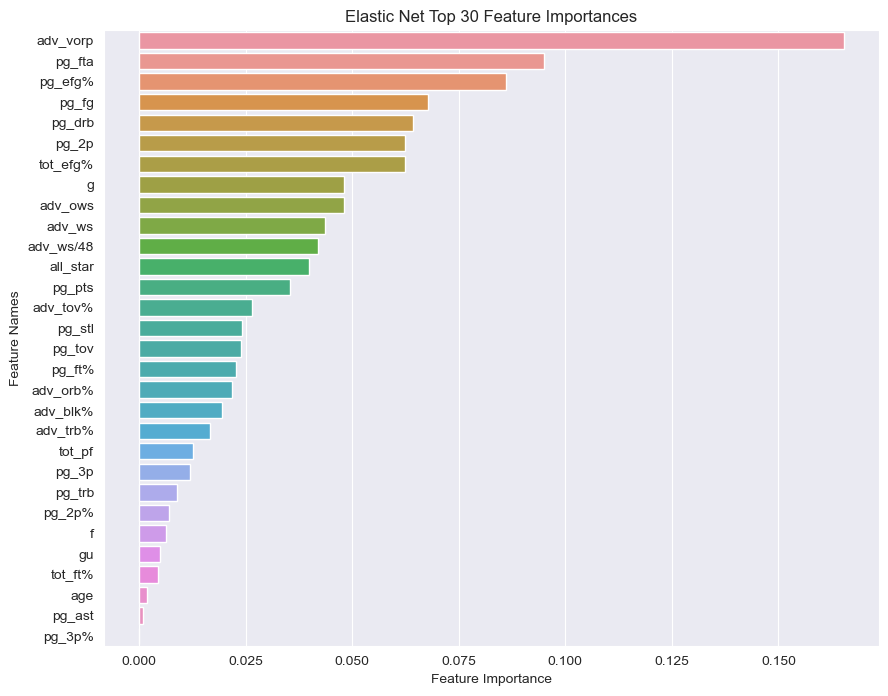

In [203]:
#Sort the DataFrame by descending
plt.figure(figsize=(10,8))
sns.barplot(x=f12['feature_importance'], y=f12['feature_names'])
plt.title('Elastic Net Top 30 Feature Importances')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names');

#plt.savefig('../images/Feature_Importances_RF.png', dpi=192, bbox_inches='tight'); #Added

In [211]:
# EXTRA TREES
pipe_et = Pipeline([
    ('sc', StandardScaler()),
    ('et', ExtraTreesRegressor())
])

pipe_et.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()), ('et', ExtraTreesRegressor())],
 'verbose': False,
 'sc': StandardScaler(),
 'et': ExtraTreesRegressor(),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'et__bootstrap': False,
 'et__ccp_alpha': 0.0,
 'et__criterion': 'squared_error',
 'et__max_depth': None,
 'et__max_features': 1.0,
 'et__max_leaf_nodes': None,
 'et__max_samples': None,
 'et__min_impurity_decrease': 0.0,
 'et__min_samples_leaf': 1,
 'et__min_samples_split': 2,
 'et__min_weight_fraction_leaf': 0.0,
 'et__n_estimators': 100,
 'et__n_jobs': None,
 'et__oob_score': False,
 'et__random_state': None,
 'et__verbose': 0,
 'et__warm_start': False}

In [217]:
pgrid_et =[
    {
    'et__n_estimators': [150, 175],
    'et__max_depth': [10, 20],
    'et__max_features': [4, 5, 6],
    'et__random_state': [1527],
    'et__min_samples_leaf': [1, 3, 5],
    }
]

In [222]:
%%time

gs_et = GridSearchCV(pipe_et, pgrid_et, cv=5, scoring = 'r2', n_jobs=10)
gs_et.fit(X_train, y_train)

CPU times: total: 328 ms
Wall time: 19.2 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('et', ExtraTreesRegressor())]),
             n_jobs=10,
             param_grid=[{'et__max_depth': [10, 20],
                          'et__max_features': [4, 5, 6],
                          'et__min_samples_leaf': [1, 3, 5],
                          'et__n_estimators': [150, 175],
                          'et__random_state': [1527]}],
             scoring='r2')

In [223]:
# Make predictions for Accuracy Report
preds_et = gs_et.predict(X_test)

In [224]:
print(f'------------- {b1}Extra Trees w/ GridSearch{b0} -------------')
print(f'------------------- Train: {round(gs_et.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(gs_et.score(X_test, y_test),4)} --------------------')
print('Best Params:', gs_et.best_params_)

------------- Extra Trees w/ GridSearch -------------
------------------- Train: 0.9388 -------------------
------------------- Test: 0.8033 --------------------
Best Params: {'et__max_depth': 10, 'et__max_features': 6, 'et__min_samples_leaf': 1, 'et__n_estimators': 175, 'et__random_state': 1527}


In [225]:
gs_et.best_score_

0.2767207287544757

In [296]:
#feat_updates = ['adv_per', 'adv_ws', 'adv_vorp', 'adv_ws/48', 'adv_bpm', 'adv_obpm', 'all_star', 'tot_pts', 'pg_pts', 'pg_2p', 'adv_ows', 'w/l%', 'seed', 'adv_usg%', 'pg_tov', 
#                'adv_dws', 'pg_fta', 'pg_2pa', 'pg_fga', 'pg_ft', 'pg_ast', 'adv_dbpm', 'pg_drb', 'adv_ast%', 'pg_mp', 'pg_ft%','pg_trb', 'adv_tov%', 'tot_ft%']

In [7]:
feat_updates = ['g', 'pg_gs', 'pg_mp', 'adv_per', 'adv_ws', 'adv_vorp', 'adv_ws/48', 'adv_bpm', 'adv_obpm', 'all_star', 'tot_pts', 'pg_pts', 'pg_2p', 'adv_ts%', 'adv_ows', 'w/l%', 'seed', 'adv_usg%', 'f', 'gu']

In [8]:
X_train = df[feat_updates].loc[df.year.isin(train_yrs)].reset_index(drop=True)
X_test = df[feat_updates].loc[df.year.isin(test_yrs)].reset_index(drop=True)

y_train = df['share'].loc[df.year.isin(train_yrs)]
y_test = df['share'].loc[df.year.isin(test_yrs)]

X_hold = df[feat_updates].loc[df.year.isin(hold_yrs)].reset_index(drop=True)
y_hold = df['share'].loc[df.year.isin(hold_yrs)]

print(f'Train: X: {X_train.shape}, y: {y_train.shape}')
print(f'Test: X: {X_test.shape}, y: {y_test.shape}')
print(f'Hold: X: {X_hold.shape}, y: {y_hold.shape}')

Train: X: (3554, 20), y: (3554,)
Test: X: (520, 20), y: (520,)
Hold: X: (303, 20), y: (303,)


In [9]:
pipe_svr = Pipeline([
    ('sc', StandardScaler()),
    ('svr', SVR())
])

pipe_svr.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()), ('svr', SVR())],
 'verbose': False,
 'sc': StandardScaler(),
 'svr': SVR(),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'svr__C': 1.0,
 'svr__cache_size': 200,
 'svr__coef0': 0.0,
 'svr__degree': 3,
 'svr__epsilon': 0.1,
 'svr__gamma': 'scale',
 'svr__kernel': 'rbf',
 'svr__max_iter': -1,
 'svr__shrinking': True,
 'svr__tol': 0.001,
 'svr__verbose': False}

In [10]:
pgrid_svr =[
    {
     'svr__C': np.linspace(0.0001, 2, 10),
     'svr__kernel': ['rbf'], #poly, 'linear'],
     'svr__degree': [2, 3, 4],
     'svr__gamma': ['scale','auto'],
     'svr__epsilon': [0.1, 0.5, 1]
    }
]

In [11]:
%%time

gs_svr = GridSearchCV(pipe_svr, pgrid_svr, n_jobs=25)
gs_svr.fit(X_train, y_train)

CPU times: total: 4.3 s
Wall time: 20.1 s


GridSearchCV(estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=25,
             param_grid=[{'svr__C': array([1.00000000e-04, 2.22311111e-01, 4.44522222e-01, 6.66733333e-01,
       8.88944444e-01, 1.11115556e+00, 1.33336667e+00, 1.55557778e+00,
       1.77778889e+00, 2.00000000e+00]),
                          'svr__degree': [2, 3, 4],
                          'svr__epsilon': [0.1, 0.5, 1],
                          'svr__gamma': ['scale', 'auto'],
                          'svr__kernel': ['rbf']}])

In [12]:
# Make predictions
preds_svr = gs_svr.predict(X_test)

In [15]:
print(f'----------------- {b1}SVR w/ GridSearch{b0} ----------------')
print(f'------------------ Train: {round(gs_svr.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(gs_svr.score(X_test, y_test),4)} -------------------')
print('Best Params:', gs_svr.best_params_)

----------------- SVR w/ GridSearch ----------------
------------------ Train: 0.8078 -------------------
------------------- Test: 0.809 -------------------
Best Params: {'svr__C': 0.2223111111111111, 'svr__degree': 2, 'svr__epsilon': 0.1, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}


In [16]:
mean_squared_error(y_test, preds_svr)

0.008330220863588972

In [569]:
# RANDOM FOREST
pipe_rf = Pipeline([
    ('sc', StandardScaler()),
    ('rf', RandomForestRegressor())
])

pipe_rf.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()), ('rf', RandomForestRegressor())],
 'verbose': False,
 'sc': StandardScaler(),
 'rf': RandomForestRegressor(),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__criterion': 'squared_error',
 'rf__max_depth': None,
 'rf__max_features': 1.0,
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 100,
 'rf__n_jobs': None,
 'rf__oob_score': False,
 'rf__random_state': None,
 'rf__verbose': 0,
 'rf__warm_start': False}

In [559]:
pgrid_rf =[
    {'rf__n_estimators': [85],
     'rf__max_depth': np.arange(20, 80, 10),
     'rf__max_features': [3,5,7],
     'rf__max_leaf_nodes': [75, 100],
     'rf__max_samples': [None]
    } 
]
# Best Params: {'rf__max_depth': 85, 'rf__max_features': 5, 'rf__max_leaf_nodes': None, 'rf__max_samples': None, 'rf__n_estimators': 200}

In [560]:
%%time

gs_rf = GridSearchCV(pipe_rf, pgrid_rf, cv=5, n_jobs=25)
gs_rf.fit(X_train, y_train)

CPU times: total: 328 ms
Wall time: 9.07 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('rf', RandomForestRegressor())]),
             n_jobs=25,
             param_grid=[{'rf__max_depth': array([20, 30, 40, 50, 60, 70]),
                          'rf__max_features': [3, 5, 7],
                          'rf__max_leaf_nodes': [75, 100],
                          'rf__max_samples': [None],
                          'rf__n_estimators': [85]}])

In [561]:
preds_rf = gs_rf.predict(X_test)

In [562]:
print(f'------------- {b1}Random Forest w/ GridSearch{b0} ------------')
print(f'------------------- Train: {round(gs_rf.score(X_train, y_train),4)} --------------------')
print(f'------------------- Test: {round(gs_rf.score(X_test, y_test),4)} ---------------------')
print('Best Params:', gs_rf.best_params_)

------------- Random Forest w/ GridSearch ------------
------------------- Train: 0.9386 --------------------
------------------- Test: 0.8056 ---------------------
Best Params: {'rf__max_depth': 50, 'rf__max_features': 3, 'rf__max_leaf_nodes': 100, 'rf__max_samples': None, 'rf__n_estimators': 85}


In [ ]:
best_estimator = gs_rf.best_estimator_

In [570]:
# source: https://github.com/scikit-learn/scikit-learn/issues/21349, ChatGPT
best_estimator = gs_rf.best_estimator_
random_forest = best_estimator.named_steps['rf']
feature_importances = random_forest.feature_importances_
best_preprocessor = best_estimator.named_steps['sc']

feature_names = best_preprocessor.get_feature_names_out()
feature_names_list = list(feature_names)

print(feature_names)
print(feature_importances)

['g' 'pg_gs' 'pg_mp' 'adv_per' 'adv_ws' 'adv_vorp' 'adv_ws/48' 'adv_bpm'
 'adv_obpm' 'all_star' 'tot_pts' 'pg_pts' 'pg_2p' 'adv_ts%' 'adv_ows'
 'w/l%' 'seed' 'adv_usg%' 'f' 'gu']
[0.01112466 0.01035761 0.01511947 0.12941363 0.14311735 0.15832004
 0.06049333 0.07313755 0.04488368 0.05646531 0.04484959 0.04865175
 0.04351798 0.0143377  0.04146938 0.02949551 0.0239655  0.0476808
 0.00162489 0.00197428]


In [571]:
# Make df
fi = pd.DataFrame({'feature_names':feature_names,
                   'feature_importance': feature_importances})

#Sort by creasing feature importance
fi.sort_values(by=['feature_importance'], ascending=False,inplace=True)
fi2 = fi.reset_index().drop(columns = ['index']).head(30)

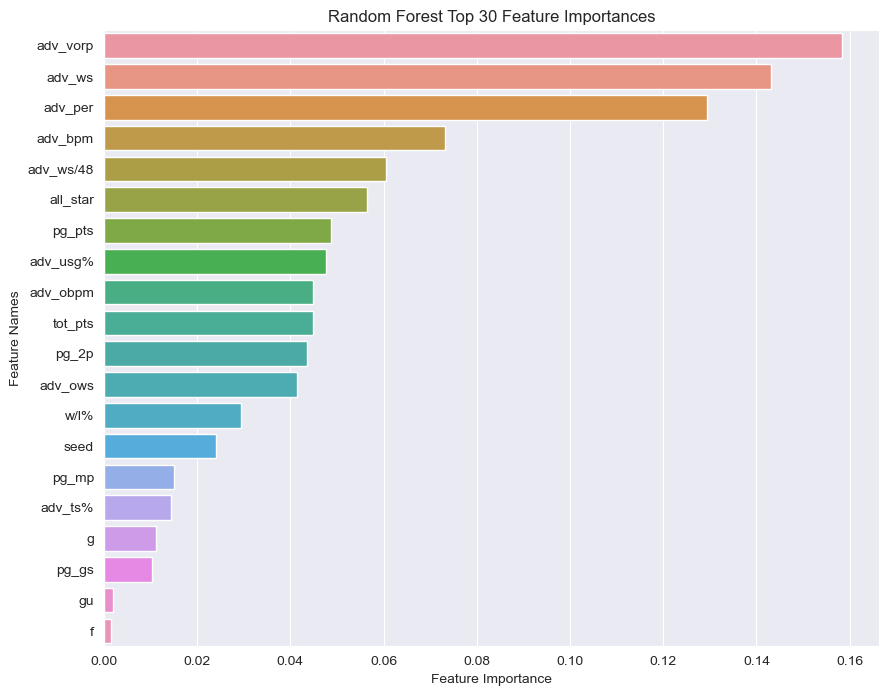

In [572]:
#Sort the DataFrame by descending
plt.figure(figsize=(10,8))
sns.barplot(x=fi2['feature_importance'], y=fi2['feature_names'])
plt.title('Random Forest Top 30 Feature Importances')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names');

#plt.savefig('../images/Feature_Importances_RF.png', dpi=192, bbox_inches='tight'); #Added

In [573]:
# EXTRA TREES
pipe_et = Pipeline([
    ('sc', StandardScaler()),
    ('et', ExtraTreesRegressor())
])

pipe_et.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()), ('et', ExtraTreesRegressor())],
 'verbose': False,
 'sc': StandardScaler(),
 'et': ExtraTreesRegressor(),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'et__bootstrap': False,
 'et__ccp_alpha': 0.0,
 'et__criterion': 'squared_error',
 'et__max_depth': None,
 'et__max_features': 1.0,
 'et__max_leaf_nodes': None,
 'et__max_samples': None,
 'et__min_impurity_decrease': 0.0,
 'et__min_samples_leaf': 1,
 'et__min_samples_split': 2,
 'et__min_weight_fraction_leaf': 0.0,
 'et__n_estimators': 100,
 'et__n_jobs': None,
 'et__oob_score': False,
 'et__random_state': None,
 'et__verbose': 0,
 'et__warm_start': False}

In [574]:
pgrid_et =[
    {
    'et__n_estimators': [150, 175],
    'et__max_depth': [10, 20],
    'et__max_features': [4, 5, 6],
    'et__random_state': [1527],
    'et__min_samples_leaf': [1, 3, 5],
    }
]

In [575]:
%%time

gs_et = GridSearchCV(pipe_et, pgrid_et, cv=5, scoring = 'r2', n_jobs=10)
gs_et.fit(X_train, y_train)

CPU times: total: 281 ms
Wall time: 18.2 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('et', ExtraTreesRegressor())]),
             n_jobs=10,
             param_grid=[{'et__max_depth': [10, 20],
                          'et__max_features': [4, 5, 6],
                          'et__min_samples_leaf': [1, 3, 5],
                          'et__n_estimators': [150, 175],
                          'et__random_state': [1527]}],
             scoring='r2')

In [576]:
preds_et = gs_et.predict(X_test)

In [577]:
print(f'------------- {b1}Extra Trees w/ GridSearch{b0} -------------')
print(f'------------------- Train: {round(gs_et.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(gs_et.score(X_test, y_test),4)} --------------------')
print('Best Params:', gs_et.best_params_)

------------- Extra Trees w/ GridSearch -------------
------------------- Train: 0.925 -------------------
------------------- Test: 0.8147 --------------------
Best Params: {'et__max_depth': 10, 'et__max_features': 4, 'et__min_samples_leaf': 1, 'et__n_estimators': 175, 'et__random_state': 1527}


In [578]:
gs_et.best_score_

0.27408771367152884

In [580]:
# source: https://github.com/scikit-learn/scikit-learn/issues/21349, ChatGPT
best_estimator = gs_et.best_estimator_
extra = best_estimator.named_steps['et']
feature_importances = extra.feature_importances_
best_preprocessor = best_estimator.named_steps['sc']

feature_names = best_preprocessor.get_feature_names_out()
feature_names_list = list(feature_names)

print(feature_names)
print(feature_importances)

['g' 'pg_gs' 'pg_mp' 'adv_per' 'adv_ws' 'adv_vorp' 'adv_ws/48' 'adv_bpm'
 'adv_obpm' 'all_star' 'tot_pts' 'pg_pts' 'pg_2p' 'adv_ts%' 'adv_ows'
 'w/l%' 'seed' 'adv_usg%' 'f' 'gu']
[0.0082024  0.00773615 0.01247747 0.10211351 0.07652584 0.10056284
 0.06584913 0.07563959 0.05668796 0.18373608 0.05104979 0.05841126
 0.04655974 0.0101325  0.04542812 0.02544459 0.03618998 0.02739451
 0.00476205 0.00509648]


In [581]:
# Make df
fi = pd.DataFrame({'feature_names':feature_names,
                   'feature_importance': feature_importances})

#Sort by creasing feature importance
fi.sort_values(by=['feature_importance'], ascending=False,inplace=True)
fi2 = fi.reset_index().drop(columns = ['index']).head(30)

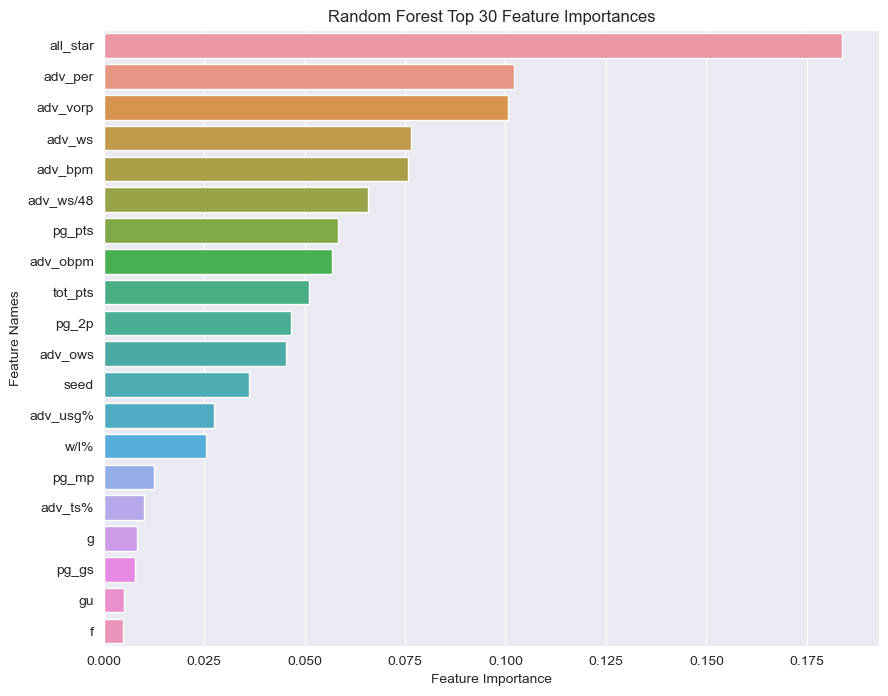

In [582]:
#Sort the DataFrame by descending
plt.figure(figsize=(10,8))
sns.barplot(x=fi2['feature_importance'], y=fi2['feature_names'])
plt.title('Extra Trees Top 30 Feature Importances')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names');

#plt.savefig('../images/Feature_Importances_RF.png', dpi=192, bbox_inches='tight'); #Added

In [589]:
mean_squared_error(y_test, preds_et)

0.008082222788798768

In [ ]:
## XBG

In [583]:
pipe_xgb = Pipeline([
    ('sc', StandardScaler()),
    #('pc', PCA()),
    ('xgb', XGBRegressor(random_state=1527))
])

pipe_xgb.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()),
  ('xgb',
   XGBRegressor(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                predictor=None, random_state=1527, ...))],
 'verbose': False,
 'sc': StandardScaler(),
 'xgb': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample

In [ ]:
pgrid_xgb = [{
     'xgb__n_estimators': [None],
     'xgb__max_depth': [None],
     'xgb__learning_rate': np.linspace(0.1, .5, 10),
     'xgb__subsample': [0.8, 0.9, 1.0],
     'xgb__colsample_bytree': [None],
     'xgb__reg_alpha': [0.01, 0.1, 1.0, 10]
    
    }]


pgrid_xgb = [{
     'xgb__n_estimators': [50],
     'xgb__max_depth': [5, 10, 15, 20],
     'xgb__learning_rate': np.linspace(0.1, .5, 10),
     'xgb__subsample': [None],
     'xgb__colsample_bytree': [None],
     'xgb__reg_alpha': [None]
    
    }] 77%

In [584]:
pgrid_xgb = [{
     'xgb__n_estimators': [65],
     'xgb__max_depth': [3,4,5,6],
     'xgb__learning_rate': np.linspace(0.01, .5, 10),
     'xgb__subsample': [None],
     'xgb__colsample_bytree': [None],
     'xgb__reg_alpha': [0.15]
    
    }]

gs_xgb = GridSearchCV(pipe_xgb, pgrid_xgb, cv=5, n_jobs=15)

In [585]:
%%time

gs_xgb = GridSearchCV(pipe_xgb, pgrid_xgb, cv=5, n_jobs=10)
gs_xgb.fit(X_train, y_train)

CPU times: total: 438 ms
Wall time: 5.32 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('xgb',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None, gpu_id=None,
                                                     grow_policy=None,
                                                     importance_type=None,
                                                     in...
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=1527, ...))]),
             n_jobs=10,
             param_grid=[{'xgb__colsample_bytree': [None],
                          'xgb__learning_rate': array([0.01      , 0.06444444, 0.11888889, 0.17333333, 0.22777778,
       0.28222222, 0.33666667, 0.39111111, 0.44555556, 0.5       ]),
                          'xgb__max_depth': [3, 4, 5, 6],
                          'xgb__n_estimators': [65], 'xgb__reg_alpha': [0.15],
                          'xgb__subsample': [None]}])

In [586]:
# Make predictions for Accuracy Report
preds_xgb = gs_xgb.predict(X_test)

In [587]:
print(f'------------- {b1}Xtreme Gradient Boosting w/ GridSearch{b0} -------------')
print(f'------------------- Train: {round(gs_xgb.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(gs_xgb.score(X_test, y_test),4)} --------------------')
print('Best Params:', gs_xgb.best_params_)

------------- Extra Trees w/ GridSearch -------------
------------------- Train: 0.8492 -------------------
------------------- Test: 0.7852 --------------------
Best Params: {'xgb__colsample_bytree': None, 'xgb__learning_rate': 0.06444444444444444, 'xgb__max_depth': 3, 'xgb__n_estimators': 65, 'xgb__reg_alpha': 0.15, 'xgb__subsample': None}


In [588]:
mean_squared_error(y_test, preds_xgb)

0.009372373183146076

In [ ]:
## Gradient Boosting Regressor

In [594]:
pipe_gb = Pipeline([
    ('sc', StandardScaler()),
    #('pc', PCA()),
    ('gb', GradientBoostingRegressor(random_state=1527))
])

pipe_gb.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()),
  ('gb', GradientBoostingRegressor(random_state=1527))],
 'verbose': False,
 'sc': StandardScaler(),
 'gb': GradientBoostingRegressor(random_state=1527),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'gb__alpha': 0.9,
 'gb__ccp_alpha': 0.0,
 'gb__criterion': 'friedman_mse',
 'gb__init': None,
 'gb__learning_rate': 0.1,
 'gb__loss': 'squared_error',
 'gb__max_depth': 3,
 'gb__max_features': None,
 'gb__max_leaf_nodes': None,
 'gb__min_impurity_decrease': 0.0,
 'gb__min_samples_leaf': 1,
 'gb__min_samples_split': 2,
 'gb__min_weight_fraction_leaf': 0.0,
 'gb__n_estimators': 100,
 'gb__n_iter_no_change': None,
 'gb__random_state': 1527,
 'gb__subsample': 1.0,
 'gb__tol': 0.0001,
 'gb__validation_fraction': 0.1,
 'gb__verbose': 0,
 'gb__warm_start': False}

In [608]:
pgrid_gb = [{
     'gb__n_estimators': [30],
     'gb__max_depth': [3],
     'gb__learning_rate': np.linspace(0.01, .5, 10),
     'gb__alpha': np.linspace(0.01, .5, 10)
    }]

gs_gb = GridSearchCV(pipe_gb, pgrid_gb, cv=5, n_jobs=15)

In [609]:
%%time

gs_gb = GridSearchCV(pipe_gb, pgrid_gb, cv=5, n_jobs=10)
gs_gb.fit(X_train, y_train)

CPU times: total: 969 ms
Wall time: 2min 51s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('gb',
                                        GradientBoostingRegressor(random_state=1527))]),
             n_jobs=10,
             param_grid=[{'gb__alpha': array([0.01      , 0.06444444, 0.11888889, 0.17333333, 0.22777778,
       0.28222222, 0.33666667, 0.39111111, 0.44555556, 0.5       ]),
                          'gb__learning_rate': array([0.01      , 0.06444444, 0.11888889, 0.17333333, 0.22777778,
       0.28222222, 0.33666667, 0.39111111, 0.44555556, 0.5       ]),
                          'gb__max_depth': [None, 3],
                          'gb__n_estimators': [30]}])

In [610]:
# Make predictions for Accuracy Report
preds_gb = gs_gb.predict(X_test)

In [611]:
print(f'------------- {b1}Gradient Boosting w/ GridSearch{b0} -------------')
print(f'------------------- Train: {round(gs_gb.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(gs_gb.score(X_test, y_test),4)} --------------------')
print('Best Params:', gs_gb.best_params_)

------------- Extra Trees w/ GridSearch -------------
------------------- Train: 0.8651 -------------------
------------------- Test: 0.7998 --------------------
Best Params: {'gb__alpha': 0.01, 'gb__learning_rate': 0.17333333333333334, 'gb__max_depth': 3, 'gb__n_estimators': 30}


In [612]:
mean_squared_error(y_test, preds_gb)

0.00873423257870833

In [615]:
pipe_ada = Pipeline([
    ('sc', StandardScaler()),
    #('pc', PCA()),
    ('ada', AdaBoostRegressor(random_state=1527))
])

pipe_ada.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()),
  ('ada', AdaBoostRegressor(random_state=1527))],
 'verbose': False,
 'sc': StandardScaler(),
 'ada': AdaBoostRegressor(random_state=1527),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'ada__base_estimator': 'deprecated',
 'ada__estimator': None,
 'ada__learning_rate': 1.0,
 'ada__loss': 'linear',
 'ada__n_estimators': 50,
 'ada__random_state': 1527}

In [648]:
pgrid_ada = [{
     'ada__n_estimators': [70],
     'ada__learning_rate': np.linspace(0.01, .5, 15)
    }]

gs_ada = GridSearchCV(pipe_ada, pgrid_ada, cv=5, n_jobs=5)

In [649]:
%%time

gs_ada = GridSearchCV(pipe_ada, pgrid_ada, cv=5, n_jobs=5)
gs_ada.fit(X_train, y_train)

CPU times: total: 219 ms
Wall time: 10.4 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('ada',
                                        AdaBoostRegressor(random_state=1527))]),
             n_jobs=5,
             param_grid=[{'ada__learning_rate': array([0.01 , 0.045, 0.08 , 0.115, 0.15 , 0.185, 0.22 , 0.255, 0.29 ,
       0.325, 0.36 , 0.395, 0.43 , 0.465, 0.5  ]),
                          'ada__n_estimators': [70]}])

In [650]:
# Make predictions for Accuracy Report
preds_ada = gs_ada.predict(X_test)

In [651]:
print(f'------------- {b1}AdaBoost w/ GridSearch{b0} -------------')
print(f'------------------- Train: {round(gs_ada.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(gs_ada.score(X_test, y_test),4)} --------------------')
print('Best Params:', gs_ada.best_params_)

------------- AdaBoost w/ GridSearch -------------
------------------- Train: 0.7784 -------------------
------------------- Test: 0.7338 --------------------
Best Params: {'ada__learning_rate': 0.07999999999999999, 'ada__n_estimators': 70}


In [652]:
mean_squared_error(y_test, preds_ada)

0.011611047634190803

In [23]:
pipe_lgbm = Pipeline([
    ('sc', StandardScaler()),
    #('pc', PCA()),
    ('lgbm', LGBMRegressor(random_state=1527))
])

pipe_lgbm.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()),
  ('lgbm', LGBMRegressor(random_state=1527))],
 'verbose': False,
 'sc': StandardScaler(),
 'lgbm': LGBMRegressor(random_state=1527),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'lgbm__boosting_type': 'gbdt',
 'lgbm__class_weight': None,
 'lgbm__colsample_bytree': 1.0,
 'lgbm__importance_type': 'split',
 'lgbm__learning_rate': 0.1,
 'lgbm__max_depth': -1,
 'lgbm__min_child_samples': 20,
 'lgbm__min_child_weight': 0.001,
 'lgbm__min_split_gain': 0.0,
 'lgbm__n_estimators': 100,
 'lgbm__n_jobs': None,
 'lgbm__num_leaves': 31,
 'lgbm__objective': None,
 'lgbm__random_state': 1527,
 'lgbm__reg_alpha': 0.0,
 'lgbm__reg_lambda': 0.0,
 'lgbm__subsample': 1.0,
 'lgbm__subsample_for_bin': 200000,
 'lgbm__subsample_freq': 0}

In [33]:
pgrid_lgbm = [{
     'lgbm__learning_rate': np.linspace(0.01, .5, 15),
     'lgbm__max_depth': [5],
     'lgbm__n_estimators': [100],
     'lgbm__num_leaves': [12],
    }]

gs_lgbm = GridSearchCV(pipe_lgbm, pgrid_lgbm, cv=5, n_jobs=5)

81.95%

In [61]:
%%time

gs_lgbm = GridSearchCV(pipe_lgbm, pgrid_lgbm, cv=5, n_jobs=5)
gs_lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2348
[LightGBM] [Info] Number of data points in the train set: 3554, number of used features: 20
[LightGBM] [Info] Start training from score 0.068363
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('lgbm',
                                        LGBMRegressor(random_state=1527))]),
             n_jobs=5,
             param_grid=[{'lgbm__learning_rate': array([0.01 , 0.045, 0.08 , 0.115, 0.15 , 0.185, 0.22 , 0.255, 0.29 ,
       0.325, 0.36 , 0.395, 0.43 , 0.465, 0.5  ]),
                          'lgbm__max_depth': [5], 'lgbm__n_estimators': [100],
                          'lgbm__num_leaves': [12]}])

In [62]:
# Make predictions for Accuracy Report
preds_lgbm = gs_lgbm.predict(X_test)

In [63]:
print(f'------------- {b1}LGBM w/ GridSearch{b0} -------------')
print(f'------------------- Train: {round(gs_lgbm.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(gs_lgbm.score(X_test, y_test),4)} --------------------')
print('Best Params:', gs_lgbm.best_params_)

------------- LGBM w/ GridSearch -------------
------------------- Train: 0.8886 -------------------
------------------- Test: 0.8195 --------------------
Best Params: {'lgbm__learning_rate': 0.045, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 100, 'lgbm__num_leaves': 12}


In [65]:
mean_squared_error(y_test, preds_lgbm)

0.007875992402257342

In [322]:
feats = ['age', 'g', 'pg_gs', 'pg_mp', 'pg_fg', 'pg_fga', 'pg_fg%', 'pg_3p', 'pg_3pa', 'pg_3p%', 'pg_2p', 'pg_2pa', 'pg_2p%', 'pg_efg%', 'pg_ft', 'pg_fta', 'pg_ft%', 'pg_orb', 'pg_drb', 'pg_trb', 'pg_ast', 'pg_stl', 'pg_blk', 'pg_tov', 'pg_pf', 'pg_pts', 'tot_mp', 'tot_fg%', 'tot_3p', 'tot_3p%', 'tot_2p%', 'tot_efg%', 'tot_ft%', 'tot_pf', 'tot_pts', 'adv_per', 'adv_ts%', 'adv_3par', 'adv_ftr', 'adv_orb%', 'adv_drb%', 'adv_trb%', 'adv_ast%', 'adv_stl%', 'adv_blk%', 'adv_tov%', 'adv_usg%', 'adv_ows', 'adv_dws', 'adv_ws', 'adv_ws/48', 'adv_obpm', 'adv_dbpm', 'adv_bpm', 'adv_vorp', 'f', 'gu', 'w/l%', 'seed', 'all_star']

In [323]:
X_train = df[feats].loc[df.year.isin(train_yrs)].reset_index(drop=True)
X_test = df[feats].loc[df.year.isin(test_yrs)].reset_index(drop=True)

y_train = df['share'].loc[df.year.isin(train_yrs)]
y_test = df['share'].loc[df.year.isin(test_yrs)]

X_hold = df[feats].loc[df.year.isin(hold_yrs)].reset_index(drop=True)
y_hold = df['share'].loc[df.year.isin(hold_yrs)]

print(f'Train: X: {X_train.shape}, y: {y_train.shape}')
print(f'Test: X: {X_test.shape}, y: {y_test.shape}')
print(f'Hold: X: {X_hold.shape}, y: {y_hold.shape}')

Train: X: (3554, 60), y: (3554,)
Test: X: (520, 60), y: (520,)
Hold: X: (303, 60), y: (303,)


In [324]:
pipe_rf2 = Pipeline([
    ('sc', StandardScaler()),
    ('pc', PCA()),
    ('rf', RandomForestRegressor())
])

pipe_rf2.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()),
  ('pc', PCA()),
  ('rf', RandomForestRegressor())],
 'verbose': False,
 'sc': StandardScaler(),
 'pc': PCA(),
 'rf': RandomForestRegressor(),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'pc__copy': True,
 'pc__iterated_power': 'auto',
 'pc__n_components': None,
 'pc__n_oversamples': 10,
 'pc__power_iteration_normalizer': 'auto',
 'pc__random_state': None,
 'pc__svd_solver': 'auto',
 'pc__tol': 0.0,
 'pc__whiten': False,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__criterion': 'squared_error',
 'rf__max_depth': None,
 'rf__max_features': 1.0,
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 100,
 'rf__n_jobs': None,
 'rf__oob_score': False,
 'rf__random_state': None,
 'rf__verbose': 0,
 'rf__warm_start': False}

In [334]:
pgrid_rf2 = [{
     #'pc__n_components': np.arange(1, 60),
      
     'rf__max_depth': [60], 
     'rf__max_features': [3], 
     'rf__max_leaf_nodes': [125], 
     'rf__max_samples': [None], 
     'rf__n_estimators': [150]
    }]

gs = GridSearchCV(pipe_rf2, pgrid, cv=5, n_jobs=5)

In [335]:
%%time

gs_rf2 = GridSearchCV(pipe_rf2, pgrid_rf2, cv=5, scoring = 'r2', n_jobs=10)
gs_rf2.fit(X_train, y_train)

CPU times: total: 328 ms
Wall time: 1min 28s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()), ('pc', PCA()),
                                       ('rf', RandomForestRegressor())]),
             n_jobs=10,
             param_grid=[{'pc__n_components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59]),
                          'rf__max_depth': [60], 'rf__max_features': [3],
                          'rf__max_leaf_nodes': [125],
                          'rf__max_samples': [None],
                          'rf__n_estimators': [150]}],
             scoring='r2')

In [590]:
# Make predictions for Accuracy Report
preds_rf2 = gs_rf2.predict(X_test)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- adv_3par
- adv_ast%
- adv_blk%
- adv_dbpm
- adv_drb%
- ...


In [347]:
print(f'------------- {b1}Extra Trees w/ GridSearch{b0} -------------')
print(f'------------------- Train: {round(gs_rf2.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(gs_rf2.score(X_test, y_test),4)} --------------------')
print('Best Params:', gs_rf2.best_params_)

------------- Extra Trees w/ GridSearch -------------
------------------- Train: 0.9459 -------------------
------------------- Test: 0.7305 --------------------
Best Params: {'pc__n_components': 9, 'rf__max_depth': 60, 'rf__max_features': 3, 'rf__max_leaf_nodes': 125, 'rf__max_samples': None, 'rf__n_estimators': 150}


In [ ]:
best_rf2 = gs_rf2.best_estimator_
pca_step = best_rf2.named_steps['pc']

In [350]:
# Access the explained variance ratio
explained_variance_ratio = pca_step.explained_variance_ratio_
explained_variance_ratio

array([0.26580234, 0.21797713, 0.11010969, 0.0646503 , 0.05242646,
       0.04495231, 0.033274  , 0.02776955, 0.0224932 ])

In [ ]:
# Access the PCA components (principal axes in feature space, representing the directions of maximum variance)
pca_components = pca_step.components_

In [ ]:
# Identify the column names with the highest explained variance
num_components = len(explained_variance_ratio)
highest_variance_column_indices = pca_components.argsort(axis=1)[:, ::-1][:, :num_components]

In [ ]:
# Get the column names from the original feature set
original_feature_names = X_train.columns

In [ ]:
# Get the column names with the highest explained variance
columns_with_highest_variance = [original_feature_names[idx] for idx in highest_variance_column_indices]

In [ ]:
# Print the explained variance ratios and associated columns
for i in range(num_components):
    print(f"Principal Component {i+1}: Explained Variance Ratio = {explained_variance_ratio[i]:.4f}")
    print(f"Columns with Highest Variance: {columns_with_highest_variance[i]}\n")

## Gradient Boosting Regressor

In [ ]:
AdaBoost

In [ ]:
Dense Neural Net

In [372]:
# Set y to be the quality column.
X = df.drop(columns=['share', 'player', 'year', 'tm', 'pos', 'pos_5', 'pos_3', 'team', 'conf', 'div', 'champs', 'all_nba_team',
                    'salary_cap', 'salary_cap_adj', 'payroll', 'payroll_adj', 'salary', 'salary_adj'])
y = df['share']

X_sc = StandardScaler().fit_transform(X)

#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2022)

In [373]:
pc = PCA()
Z = pc.fit_transform(X_sc)

In [374]:
# Sigmas scaled to sum to 100%
pc.explained_variance_ratio_

array([2.73115888e-01, 1.93729591e-01, 9.76015110e-02, 6.33761109e-02,
       4.91669682e-02, 3.97305822e-02, 3.49503848e-02, 2.43212178e-02,
       2.27278107e-02, 2.00709568e-02, 1.78719891e-02, 1.65561378e-02,
       1.45277621e-02, 1.32711054e-02, 1.21551654e-02, 1.11051070e-02,
       1.07198368e-02, 9.83756456e-03, 9.04384909e-03, 8.62640023e-03,
       7.11479558e-03, 6.87341539e-03, 6.01209641e-03, 5.73869749e-03,
       5.33804791e-03, 4.07538851e-03, 3.62717697e-03, 3.25220138e-03,
       2.52478745e-03, 1.66298566e-03, 1.51974558e-03, 1.24263502e-03,
       1.14466046e-03, 9.63090835e-04, 9.32103852e-04, 7.47092526e-04,
       5.68959968e-04, 5.43705169e-04, 4.76039468e-04, 4.07938404e-04,
       3.83639735e-04, 3.18141451e-04, 2.69939746e-04, 1.98912401e-04,
       1.96861333e-04, 1.78458507e-04, 1.42827145e-04, 1.27863986e-04,
       1.22008727e-04, 1.07690920e-04, 9.37226126e-05, 8.35357098e-05,
       6.88106245e-05, 6.74233574e-05, 6.03945155e-05, 5.69255574e-05,
      

In [376]:
pc.components_

array([[-7.47875279e-03,  5.03443325e-02,  9.70499208e-02, ...,
         6.24253122e-02, -6.28306676e-02,  2.52485249e-02],
       [ 5.32760761e-03,  8.54185330e-03,  2.03054779e-02, ...,
         1.84447516e-02, -1.69301070e-02,  2.60267873e-03],
       [ 8.45425100e-02, -2.70095172e-02, -3.99583016e-02, ...,
         2.16547712e-01, -2.07540991e-01,  7.03219688e-02],
       ...,
       [ 0.00000000e+00, -3.40248834e-16, -2.95972807e-02, ...,
        -4.16333634e-17,  8.67361738e-18,  6.24500451e-17],
       [ 0.00000000e+00, -8.88275160e-17, -1.46254807e-01, ...,
         2.18575158e-16, -7.63278329e-17,  1.38777878e-17],
       [ 0.00000000e+00, -6.93889390e-17, -1.84180070e-02, ...,
        -1.73472348e-16, -9.71445147e-17,  4.16333634e-17]])

In [377]:
# This is the VT matrix
pc.components_[:3, :3]

array([[-0.00747875,  0.05034433,  0.09704992],
       [ 0.00532761,  0.00854185,  0.02030548],
       [ 0.08454251, -0.02700952, -0.0399583 ]])

In [378]:
# Proof
u, s, vh = np.linalg.svd(X)
vh[:3, :3]

array([[-0.00857195, -0.02326099, -0.02052313],
       [ 0.00983782,  0.02681592,  0.01227335],
       [ 0.00031671,  0.00234709,  0.00795999]])

In [379]:
# Each row of VT (aka each column of V) tells us how much of each X went into each PC
vh[0, :]

array([-8.57194967e-03, -2.32609902e-02, -2.05231285e-02, -1.04862867e-02,
       -1.93906480e-03, -4.16098757e-03, -1.49239277e-04, -3.26683455e-04,
       -9.03820174e-04, -9.36366610e-05, -1.61267060e-03, -3.25720360e-03,
       -1.57933536e-04, -1.61772054e-04, -1.03038556e-03, -1.32774358e-03,
       -2.47491849e-04, -4.83562544e-04, -1.41005034e-03, -1.89326141e-03,
       -1.16850771e-03, -3.57360482e-04, -2.13804427e-04, -6.86009413e-04,
       -8.00861256e-04, -5.23540273e-03, -2.05231285e-02, -7.75666919e-01,
       -1.41135362e-01, -3.02595171e-01, -1.49239277e-04, -2.35422962e-02,
       -6.50375101e-02, -9.36366610e-05, -1.17593066e-01, -2.37557661e-01,
       -1.57933536e-04, -1.61772054e-04, -7.49510013e-02, -9.65676283e-02,
       -2.47491849e-04, -3.53763281e-02, -1.02591711e-01, -1.37968039e-01,
       -8.49383429e-02, -2.60785781e-02, -1.55700035e-02, -4.98948258e-02,
       -5.84596007e-02, -3.80764021e-01, -5.59592668e-03, -1.75893101e-04,
       -6.90740616e-05, -

In [380]:
# Looks like... sulfur dioxide and density contributed the most to PC1!
X.columns

Index(['age', 'g', 'pg_gs', 'pg_mp', 'pg_fg', 'pg_fga', 'pg_fg%', 'pg_3p',
       'pg_3pa', 'pg_3p%', 'pg_2p', 'pg_2pa', 'pg_2p%', 'pg_efg%', 'pg_ft',
       'pg_fta', 'pg_ft%', 'pg_orb', 'pg_drb', 'pg_trb', 'pg_ast', 'pg_stl',
       'pg_blk', 'pg_tov', 'pg_pf', 'pg_pts', 'tot_gs', 'tot_mp', 'tot_fg',
       'tot_fga', 'tot_fg%', 'tot_3p', 'tot_3pa', 'tot_3p%', 'tot_2p',
       'tot_2pa', 'tot_2p%', 'tot_efg%', 'tot_ft', 'tot_fta', 'tot_ft%',
       'tot_orb', 'tot_drb', 'tot_trb', 'tot_ast', 'tot_stl', 'tot_blk',
       'tot_tov', 'tot_pf', 'tot_pts', 'adv_per', 'adv_ts%', 'adv_3par',
       'adv_ftr', 'adv_orb%', 'adv_drb%', 'adv_trb%', 'adv_ast%', 'adv_stl%',
       'adv_blk%', 'adv_tov%', 'adv_usg%', 'adv_ows', 'adv_dws', 'adv_ws',
       'adv_ws/48', 'adv_obpm', 'adv_dbpm', 'adv_bpm', 'adv_vorp', 'gt1_pos',
       'f', 'gu', 'midseason_trade', 'pts_won', 'pts_max', 'all_nba_winner',
       'n_allstar', 'all_star', 'w', 'l', 'w/l%', 'seed', 'won_championship'],
      dtype='object

In [381]:
# Looks like... sulfur dioxide and density contributed the most to PC1!
pd.DataFrame({
    'col': X.columns,
    'v': np.abs(vh[0, :])
}) #THIS IS THE RECIPE FOR THE FIRST PRINCIPAL COMPONENT

pd.DataFrame({
    'col': X.columns,
    'v': np.abs(vh[0, :])
}).sort_values(by='v', ascending=False)

,col,v
27,tot_mp,0.775667
49,tot_pts,0.380764
29,tot_fga,0.302595
35,tot_2pa,0.237558
28,tot_fg,0.141135
43,tot_trb,0.137968
34,tot_2p,0.117593
42,tot_drb,0.102592
39,tot_fta,0.096568
44,tot_ast,0.084938


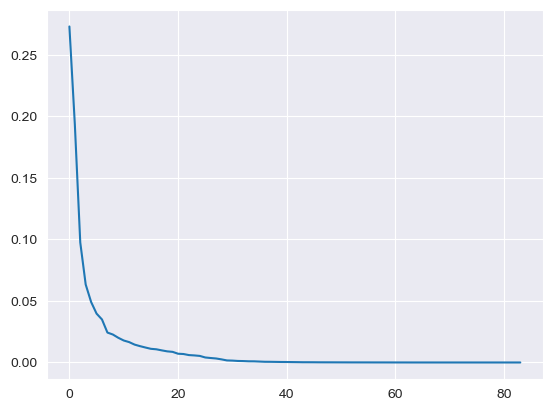

In [382]:
# Scree plot!
# An old statistician rule of thumb is to take the "elbow" of the scree plot
# as the value for which we cut the PCs.
plt.plot(pc.explained_variance_ratio_)
plt.xticks(